# paQman: Optimizing Bin-Packing For Sustainability

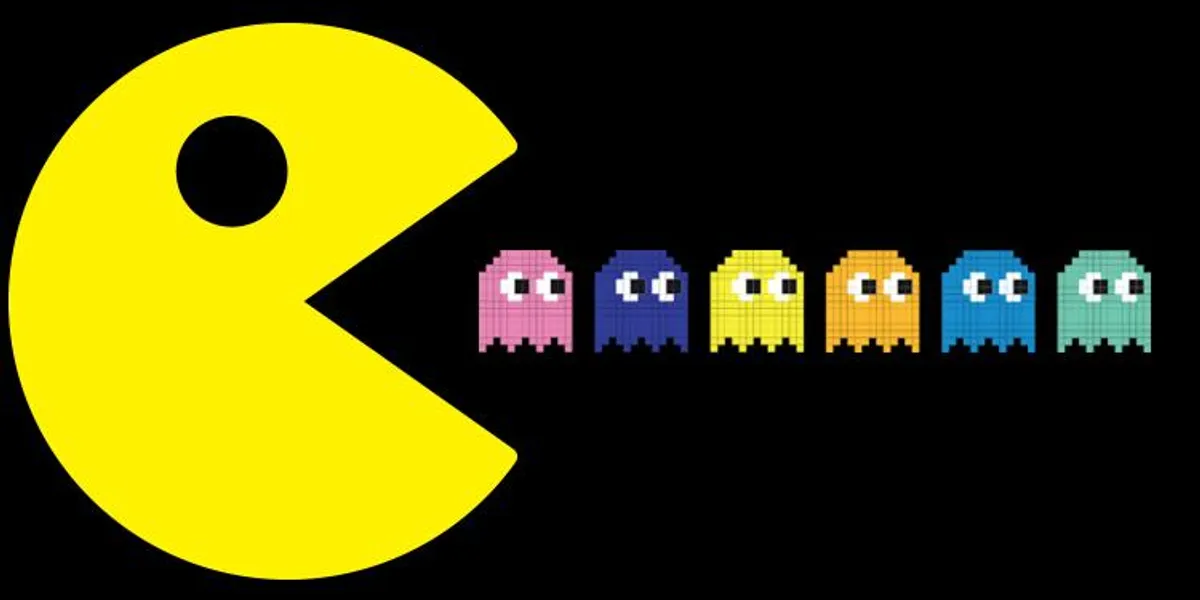


Our team aims to tackle the issue of inefficient supply-chain packing systems.

The following code cells contain optimization algorithms for bin packing. 


Box Dimension CV Model

In [ ]:
from scipy.spatial.distance import euclidean
import numpy as np
import cv2
import imutils
from imutils import perspective
from imutils import contours

# Function to display an array of images
def display_images(image_list):
    for index, image in enumerate(image_list):
        cv2.imshow("image_" + str(index), image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

image_path = "images/IMG_8626.JPG"

# Read and preprocess the image
input_image = cv2.imread(image_path)

grayscale_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(grayscale_image, (9, 9), 0)

edge_detected_image = cv2.Canny(blurred_image, 50, 100)
edge_detected_image = cv2.dilate(edge_detected_image, None, iterations=1)
edge_detected_image = cv2.erode(edge_detected_image, None, iterations=1)

# Find image contours
found_contours = cv2.findContours(edge_detected_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
found_contours = imutils.grab_contours(found_contours)

# Sort contours from left to right; leftmost contour is the reference object
(sorted_contours, _) = contours.sort_contours(found_contours)

# Filter out small contours based on area
filtered_contours = [contour for contour in sorted_contours if cv2.contourArea(contour) > 100]

# Reference object dimensions; a 3cm x 3cm box is used for reference
reference_contour = filtered_contours[0]
min_area_rect = cv2.minAreaRect(reference_contour)
rect_points = cv2.boxPoints(min_area_rect)
rect_points = np.array(rect_points, dtype="int")
ordered_rect_points = perspective.order_points(rect_points)
(top_left, top_right, bottom_right, bottom_left) = ordered_rect_points


dist_in_pixel = euclidean(top_left, top_right)
dist_in_cm = 3
pixel_per_cm = dist_in_pixel/dist_in_cm

# List to hold the areas
areas = []

# Draw remaining contours
for cnt in filtered_contours:

	# Make a box
	box = cv2.minAreaRect(cnt)
	box = cv2.boxPoints(box)
	box = np.array(box, dtype="int")
	box = perspective.order_points(box)

	(tl, tr, br, bl) = box

	cv2.drawContours(input_image, [box.astype("int")], -1, (0, 0, 255), 2)

	# Horizontal and vertical midpoints
	horizontal_mp = (tl[0] + int(abs(tr[0] - tl[0]) / 2), tl[1] + int(abs(tr[1] - tl[1]) / 2))
	vertical_mp = (tr[0] + int(abs(tr[0] - br[0]) / 2), tr[1] + int(abs(tr[1] - br[1]) / 2))

	w = euclidean(tl, tr)/pixel_per_cm
	h = euclidean(tr, br)/pixel_per_cm
	areas.append(w*h)

	cv2.putText(input_image, "{:.1f}cm".format(w), (int(horizontal_mp[0] - 15), int(horizontal_mp[1] - 10)),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
	cv2.putText(input_image, "{:.1f}cm".format(h), (int(vertical_mp[0] + 10), int(vertical_mp[1])),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

# Largest Area in the areas
largest_area = max(areas)
print(largest_area)


display_images([input_image])

In [ ]:
# Importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

# Quantum libraries and optimizers

from qiskit import BasicAer
from qiskit_optimization.runtime import QAOAClient
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp, from_gurobipy
from qiskit_optimization.runtime.vqe_client import VQEClient
from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty

In [ ]:
def data_bins(results, weights, num_bins, num_items, w=0, simplify=False):
    """
    Parameters:
      results: results of cplex optimization
      weights: (array (1,m): weights of the items
      num_bins: (int) number of bins
      num_items: (int) number of items
      w = individual item weight

    Returns:
      dictionary with items, bins, and index
    """

    # Check if the results need to be simplified
    if simplify:
        # If simplified, calculate bins and items accordingly
        bins = np.ones((num_items,))
        if num_items-w > 0:
            bins[num_items-w-1:num_items] = results[:num_items-w]

        items = np.zeros((num_items, num_bins))
        items[:, 1:] = results[num_items-w:(num_items-1)*num_bins+num_items-w].reshape(num_items, num_bins-1)
        items[0, 0] = 1
        items = items.reshape(num_items, num_bins) * weights

        return {"bins": bins, "items": items, "index": np.arange(num_items)}
    else:
        # If not simplified, return bins and items directly
        return {"bins": results[:num_items], "items": results[num_items:num_items+num_items*num_bins].reshape(num_items, num_bins) * weights,
                "index": np.arange(num_items)}


def plot_bins(results, weights, num_bins, num_items, w=0, simplify=False):
    """ plot the results of the optimization

    Parameters:
      results: results of cplex optimization
      weights: (array (1,m): weights of the items
      num_bins: (int) number of bins
      num_items: (int) number of items
      w = individual item weight

    Returns:
      None
    """
    # Compute the results using the 'data_bins' function
    res = data_bins(results.x, weights, num_bins, num_items, w, simplify)

    # Create a new figure for the bar plot
    plt.figure()

    # Get the indices for the bins
    ind = res["index"]

    # Plot the first item in each bin
    plt.bar(ind, res["items"][:,0], label=f"item {0}")
    suma = bottom=res["items"][:,0]

    # Plot the remaining items in each bin, stacked on top of the previous ones
    for j in range(1, num_bins):
        plt.bar(ind, res["items"][:,j], bottom=suma, label=f"item {j}")
        suma += res["items"][:,j]

    # Add a horizontal line representing the maximum capacity
    plt.hlines(capacity, 0-0.5, num_items-0.5, linestyle="--", color="r", label="Max W")

    # Set the ticks on the x-axis
    plt.xticks(ind)

    # Set the labels for the x-axis and y-axis
    plt.xlabel("Bin")
    plt.ylabel("Weight")

    # Display the legend for the plot
    plt.legend()

## Solution

For this initial set, we chose a small problem. Here, we select 3 items with a maximal weight of 40. The weight of the items are choose rendomly from values between 1 and the maximal weight.

First, we will use a classical solver of the problem called cplex.

Then we transform the problem to QUBO representation and solve using QAOA


In [ ]:
# Initialize test values

np.random.seed(5)
num_bins = 2 # number of bins
num_items = 2 # number of items
capacity = 20 # max weight of a bin

weights = np.random.randint(0, capacity, num_bins) # randomly choosing weight of item

In [ ]:
# Construct model using DOcplex
mdl = Model("BinPacking")

bin_vars = mdl.binary_var_list([f"bin_vars{i}" for i in range(num_bins)])  # list of variables that represent the bins
item_vars = mdl.binary_var_list([f"item_vars{i//num_items},{i%num_items}" for i in range(num_bins*num_items)])  # variables that represent the items on the specific bin

summation = mdl.sum([bin_vars[i] for i in range(num_bins)])
mdl.minimize(summation)

for j in range(num_items):
    # First set of constraints: the items must be in any bin
    constraint0 = mdl.sum([item_vars[i*num_items+j] for i in range(num_bins)])
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")

for i in range(num_bins):
    # Second set of constraints: weight constraints
    constraint1 = mdl.sum([weights[j] * item_vars[i*num_items+j] for j in range(num_items)])
    mdl.add_constraint(constraint1 <= capacity * bin_vars[i], f"cons1,{i}")

# Convert DOcplex model into Qiskit Quadratic program
qp = QuadraticProgram()
qp = from_docplex_mp(mdl)
print(qp.export_as_lp_string())

In [ ]:
# Solving Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_bins(result, weights, num_bins, num_items)

In [ ]:
# Calculate the number of bins needed (w) based on the total weight and capacity
w = int(np.ceil(np.sum(weights) / capacity))

# Set the variables for the first 'w' bins to 1
for i in range(w):
    qp = qp.substitute_variables({f"bin_vars{i}": 1})

# Set the variable for the first item in the first bin to 1
qp = qp.substitute_variables({"item_vars0,0": 1})

# Set the variables for the remaining items to 0 in the first column (representing the first bin)
for i in range(1, num_items):
    qp = qp.substitute_variables({f"item_vars{i},0": 0})

# Print the modified quadratic program as an LP (Linear Programming) string
print(qp.export_as_lp_string())

In [ ]:
simplify_result = cplex.solve(qp)
print(simplify_result)
plot_bins(simplify_result, weights, num_bins, num_items, w, simplify=True)

## QUBO Representation

### Conversion to QUBO
Qiskit's optimization module provides converters for Quadratic programs.

In [ ]:
# Initialize an InequalityToEquality object
ineq2eq = InequalityToEquality()

# Convert the quadratic program (qp) to an equivalent form with equality constraints
qp_eq = ineq2eq.convert(qp)

# Export the modified quadratic program as an LP (Linear Programming) string
print(qp_eq.export_as_lp_string())

# Print the number of variables in the modified quadratic program
print(f"The number of variables is {qp_eq.get_num_vars()}")

In [ ]:
# Initialize an IntegerToBinary object
int2bin = IntegerToBinary()

# Convert the quadratic program with equality constraints (qp_eq) to a binary representation
qp_eq_bin = int2bin.convert(qp_eq)

# Export the modified quadratic program (in binary representation) as an LP (Linear Programming) string
print(qp_eq_bin.export_as_lp_string())

# Print the number of variables in the modified quadratic program (in binary representation)
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")

In [ ]:
# Initialize a LinearEqualityToPenalty object
lineq2penalty = LinearEqualityToPenalty()

# Convert the quadratic program with equality constraints and in binary representation (qp_eq_bin)
# to a QUBO (Quadratic Unconstrained Binary Optimization) representation
qubo = lineq2penalty.convert(qp_eq_bin)

# Print the number of variables in the modified quadratic program (in binary representation)
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")

# Export the QUBO as an LP (Linear Programming) string
print(qubo.export_as_lp_string())

In [ ]:
# Solve the quadratic system and display the results
result = cplex.solve(qubo)
print(result)

In [ ]:
data_bins(result.x, weights, num_bins, num_items, w, simplify=w)
plot_bins(result, weights, num_bins, num_items, w=w, simplify=True)

### Solving using QAOA

After transforming the problem to the QUBO's representation. It's possible to use the QAOA solver of qiskit. In this section we present the results using QAOA.

In [ ]:
# Import necessary modules and classes from Qiskit
from qiskit_ibm_provider import IBMProvider  # Import IBMProvider from qiskit_ibm_provider package
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler  # Import necessary classes from qiskit_ibm_runtime package

# Initialize an IBMProvider (Account Required)
provider = IBMProvider()

# Import additional modules and classes from Qiskit
from qiskit.algorithms.optimizers import L_BFGS_B  # Import L_BFGS_B optimizer from qiskit.algorithms.optimizers
from qiskit.primitives import Sampler  # Import Sampler from qiskit.primitives
service = QiskitRuntimeService()
from qiskit import IBMQ  # Import IBMQ from qiskit package

# Configure options for Qiskit runtime
options = Options()

# Configure the provider to use the IBM Open Systems instance
provider = IBMProvider(instance="ibm-q/open/main")  # Local system

# Get the IBM QASM simulator backend
backend = service.get_backend("ibmq_qasm_simulator")

# Create a sampler instance
sampler = Sampler()

# Configure the QAOA client for quantum optimization
qaoa_mes = QAOAClient(provider=provider, backend=backend)

# Create a QAOA instance for quantum optimization using a sampler and L_BFGS_B optimizer
qaoa_mes = QAOA(sampler=Sampler(), optimizer=L_BFGS_B())

# Create a MinimumEigenOptimizer instance using QAOA as the solver
bqaoa = MinimumEigenOptimizer(qaoa_mes)

# Solve the QUBO using QAOA-based quantum optimization
result_qaoa = bqaoa.solve(qubo)

# Print the result obtained from the quantum optimization
print(result_qaoa)

In [ ]:
# Plot the Bins
plot_bins(result, weights, num_bins, num_items, w, simplify=True)
plt.title("QAOA solution", fontsize=18)